# Decision Tree on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Decision Tree</a>

<a href=#feature_importance>Feature Importance</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Decision Tree on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#verify_unbalanced>Verify on Unbalanced Dataset</a>

<a href=#feature_importance_final>Feature Importance on Final Model</a>

<a href=#bottom>Bottom</a>


In [1]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem
import pickle

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


In [3]:

# Post-aggregation
def create_dict_types_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    dtype={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype

def create_parse_dates_list_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    parse_dates= ['date_month', 'years_in_current_location']
    return parse_dates

def create_basetable(year_list, dir_prefix = ''):
    """ Reads a whole year of data from the already aggregated files and creates basetable """
    dtype = create_dict_types_aggregated_data()
    parse_dates = create_parse_dates_list_aggregated_data()
    basetable = pd.DataFrame()
    for year in year_list:
        full_year_df = pd.DataFrame()
        print('Starting with year: ', year)
        print(dir_prefix)
        blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
        for blob in blob_list:  
            if year in blob.name:
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates 
                                            )   
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
        basetable = basetable.append(full_year_df)
    print('The final number of rows of the basetable created is: ', basetable.shape[0])
    return basetable

# Calling it
data_df = create_basetable(year_list = ['2013'], dir_prefix ='03_aggregated')

Starting with year:  2013
03_aggregated
Processing file:  03_aggregated/2013_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4,58) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows of the year read is far is:  1811253
The final number of rows of the basetable created is:  1811253


In [5]:
import sys 
!{sys.executable} -m pip install imblearn

    100% |████████████████████████████████| 174kB 4.0MB/s 
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/imblearn'
Consider using the `--user` option or check the permissions.



In [4]:
data_df.shape[0]

1811253

## Check Distribution of Target:
<a href=#top>Top</a>

In [5]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1670754
True       72505
Name: has_relocated_next_year, dtype: int64 
 False    0.92243
True     0.04003
Name: has_relocated_next_year, dtype: float64


In [6]:
sum(data_df.has_relocated_next_year.isna())

67994

In [7]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [8]:
sum(data_df.has_relocated_next_year.isna())

0

In [9]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1738748
True       72505
Name: has_relocated_next_year, dtype: int64 
 False    0.95997
True     0.04003
Name: has_relocated_next_year, dtype: float64


In [10]:
HTML(DataFrame(data_df).head(10).to_html())

,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,428134.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,35.0,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_428134.0,0.0,0.0,12.0,0.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
1,0,803351.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_803351.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
2,0,810695.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_810695.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
3,0,811258.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
4,0,811333.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811333.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
5,0,818258.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_818258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
6,0,823722.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_823722.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
7,0,829630.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_829630.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
8,0,834432.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834432.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
9,0,834909.0,2015-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834909.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False


In [10]:
data_df.shape

(1811253, 58)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [11]:
print(data_df.isnull().sum())

id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              1738990
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      283138
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               25686
years_since_last_amt_consolidated_operating_result      1686012
years_since_last_amt_consolidated_revenue               1703164
years_since_last_amt_operating_result                   1686012
years_since_last_qty_employees          

In [12]:
data_df.variance_qty_issued_credit_reports.describe()

count    1.801570e+06
mean     1.398212e-01
std      5.558540e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.333333e-02
max      6.226515e+01
Name: variance_qty_issued_credit_reports, dtype: float64

In [19]:
type(data_df['years_in_current_location'])

pandas.core.series.Series

In [20]:
features_to_exclude = ('id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [139]:
len(features_in_model)

34

In [21]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [140]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [141]:
data_to_model.shape

(1811253, 35)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [142]:
data_to_model.isnull().values.any()

True

In [143]:
print(data_to_model.isnull().sum())

has_name_change                          0
delta_qty_issued_credit_reports          0
delta_score_payment_assessment           0
code_legal_form_has_changed              0
SBI_has_changed                          0
company_age                          25686
qty_green_flags                          0
qty_orange_flags                         0
qty_red_flags                            0
A                                        0
AA                                       0
AAA                                      0
B                                        0
BB                                       0
BBB                                      0
C                                        0
CC                                       0
CCC                                      0
D                                        0
NR                                       0
code_legal_form_group_1                  0
code_legal_form_group_2                  0
SBI_group_1                              0
SBI_group_2

Drop rows with NA:

In [144]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(1785567, 35)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [145]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Decision Tree:

<a href=#top>Top</a>

### Create Test/Train sets

In [146]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [147]:
x_train.shape

(1428453, 34)

In [29]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    1370470
1      57983
Name: has_relocated_next_year, dtype: int64 
 0    0.959409
1    0.040591
Name: has_relocated_next_year, dtype: float64


In [30]:
clf0 = tree.DecisionTreeClassifier()
clf0.fit(x_train, y_train)  


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.981 



## Save Model:

<a href=#top>Top</a>

In [32]:
filename = 'models/DT_2013_defaults_unbalanced.sav'
pickle.dump(clf0, open(filename, 'wb'))

In [31]:
print(clf0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


<a href=#top>Top</a>
## Paramater Tuning:

In [149]:
# 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2
clf1 = tree.DecisionTreeClassifier(max_depth=11, min_samples_split=5, min_samples_leaf=2)
clf1.fit(x_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [150]:
measure_performance(x_train,y_train,clf1, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.960 



In [21]:
GridSearchCV?

In [39]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [92]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [150]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [151]:
y_pred=clf1.predict(x_test)

In [33]:
y_pred=clf0.predict(x_test)

In [152]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[342521,    117],
       [ 14461,     15]])

In [34]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[334156,   8482],
       [ 13771,    705]])

In [35]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf0.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9377


In [36]:
y_test.value_counts() / y_test.shape[0]

0    0.959464
1    0.040536
Name: has_relocated_next_year, dtype: float64

In [37]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [38]:
score, auc, kappa

(0.937686565074458, 0.5627334510153645, 0.02902454983346392)

In [39]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    342638
           1       0.08      0.05      0.06     14476

   micro avg       0.94      0.94      0.94    357114
   macro avg       0.52      0.51      0.51    357114
weighted avg       0.92      0.94      0.93    357114



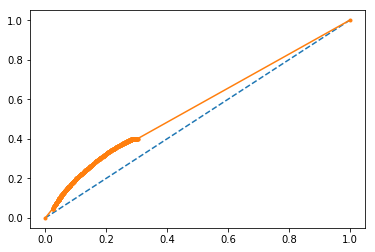

In [40]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance'></a>
# Feature Importance
<a href=#top>Top</a>

In [41]:
importances = clf0.feature_importances_

In [42]:
len(importances)

34

NameError: name 'plt' is not defined

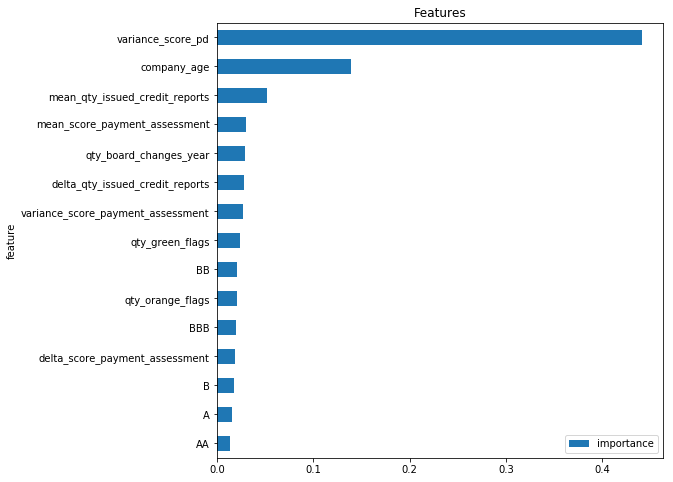

In [43]:
feat_imp = pd.DataFrame({'importance':clf0.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [44]:
len(importances)

34

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [45]:
train_all = x_train

In [46]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_score_payment_assessment',
       'variance_score_pd'],
      dtype='object')

In [47]:
train_all['has_relocated_next_year'] = y_train

In [48]:
train_all.shape

(1428453, 35)

In [49]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.959409
1    0.040591
Name: has_relocated_next_year, dtype: float64

In [50]:
# Choose desired class breakdown
fraction_majority = 0.50

In [51]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(57983, 57983, 57983.0, 0.5)

In [52]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    57983
0    57983
Name: has_relocated_next_year, dtype: int64

In [53]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [54]:
df_downsampled.shape

(115966, 35)

## Remove NaNs from Balanced Dataset:

In [55]:
data_to_model = df_downsampled[features_in_model + ['has_relocated_next_year']]

In [56]:
data_to_model.shape

(115966, 35)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [57]:
data_to_model.isnull().values.any()

False

In [58]:
print(data_to_model.isnull().sum())

has_name_change                      0
delta_qty_issued_credit_reports      0
delta_score_payment_assessment       0
code_legal_form_has_changed          0
SBI_has_changed                      0
company_age                          0
qty_green_flags                      0
qty_orange_flags                     0
qty_red_flags                        0
A                                    0
AA                                   0
AAA                                  0
B                                    0
BB                                   0
BBB                                  0
C                                    0
CC                                   0
CCC                                  0
D                                    0
NR                                   0
code_legal_form_group_1              0
code_legal_form_group_2              0
SBI_group_1                          0
SBI_group_2                          0
is_discontinued_any                  0
has_financial_calamity   

Drop rows with NA:

In [59]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(115966, 35)


In [60]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Decision Tree on Re-balanced data

<a href=#top>Top</a>

In [61]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [132]:
len(x_re_train.columns), len(x_train.columns)

(34, 35)

In [134]:
set(x_train.columns) - set(x_re_train.columns)

{'has_relocated_next_year'}

In [129]:
print obj for obj in [x_train.columns] if obj not in [x_re_train.columns]cv



SyntaxError: Missing parentheses in call to 'print' (<ipython-input-129-9e1dc598d8bd>, line 1)

In [130]:
print(obj for obj in [x_train.columns] if obj not in [x_re_train.columns])



<generator object <genexpr> at 0x7fa3bcbff518>


In [62]:
x_re_train.shape

(86974, 34)

In [63]:
clf = tree.DecisionTreeClassifier()

clf.fit(x_re_train, y_re_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [121]:
len(clf.feature_importances_)

34

In [123]:
len(x_re_train.columns), len(x_train.columns)

(34, 35)

In [64]:
# Default DT accuracy:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.891 



In [65]:
# Default DT accuracy:
measure_performance(x_re_test,y_re_test,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.588 



## Write out model:

In [66]:
filename = 'models/DT_2013defaults_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

## Tuning:

In [67]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [68]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.891 



In [69]:
tree.DecisionTreeClassifier?

In [70]:
from sklearn.metrics import cohen_kappa_score, make_scorer

kappa_scorer = make_scorer(cohen_kappa_score)

parameters = {'max_depth':range(5,25), 'min_samples_split':[5,10,15,20], 'min_samples_leaf':[2,3,5]}
clfKappa = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, scoring=kappa_scorer)
clfKappa.fit(X=x_re_train, y=y_re_train)
clfDT_Kappa = clfKappa.best_estimator_
print (clfKappa.best_score_, clfKappa.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.24192228412066571 {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}


In [71]:
filename = 'models/DT_2013md11__mss5_msl2_balanced.sav'
pickle.dump(clfDT_Kappa, open(filename, 'wb'))

In [99]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clfDT_Kappa, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.640 



## Accuracy on Test Set:

<a href=#top>Top</a>

In [74]:
y_re_pred=clfDT_Kappa.predict(x_re_test)

In [75]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[ 7120,  7265],
       [ 3704, 10903]])

In [76]:
y_re_pred=clfDT_Kappa.predict(x_re_test)

score=metrics.accuracy_score(y_re_test, y_re_pred)


# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

score, auc, kappa

(0.6216542494481236, 0.6751229828980774, 0.2418379097523734)

In [77]:
print(cr)

              precision    recall  f1-score   support

           0       0.66      0.49      0.56     14385
           1       0.60      0.75      0.67     14607

   micro avg       0.62      0.62      0.62     28992
   macro avg       0.63      0.62      0.62     28992
weighted avg       0.63      0.62      0.62     28992



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


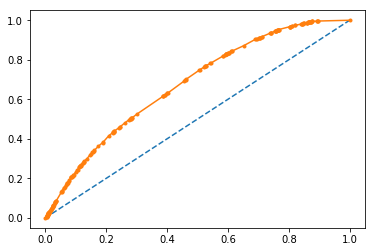

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='verify_unbalanced'></a>
## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [79]:
x_test.shape

(357114, 34)

In [81]:
y_re_pred_unbalance=clfDT_Kappa.predict(x_test)

In [82]:
y_re_pred_unbalance.shape

(357114,)

In [83]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.04053607531488544, 0.9594639246851145)

In [84]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.5141635444143887, 0.48583645558561134)

In [85]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[169889, 172749],
       [  3610,  10866]])

In [87]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [88]:
score, auc, kappa

(0.5061548973157031, 0.6790654692611466, 0.037367645064027455)

In [89]:
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.50      0.66    342638
           1       0.06      0.75      0.11     14476

   micro avg       0.51      0.51      0.51    357114
   macro avg       0.52      0.62      0.38    357114
weighted avg       0.94      0.51      0.64    357114



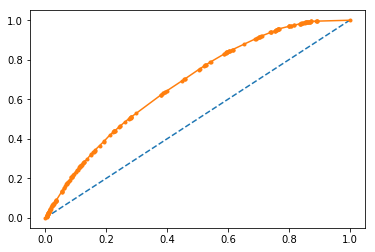

In [90]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Re-Train Optimal Tree on Unbalanced data 
<a href=#top>Top</a>

In [149]:
# 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2
clf1 = tree.DecisionTreeClassifier(max_depth=11, min_samples_split=5, min_samples_leaf=2)
clf1.fit(x_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [150]:
measure_performance(x_train,y_train,clf1, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.960 



In [153]:
y_pred=clf1.predict(x_test)

In [154]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[342521,    117],
       [ 14461,     15]])

In [155]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf1.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9592


In [157]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf1.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [158]:
score, auc, kappa

(0.9591783016067699, 0.6885559341256645, 0.0013220580608421795)

In [159]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    342638
           1       0.11      0.00      0.00     14476

   micro avg       0.96      0.96      0.96    357114
   macro avg       0.54      0.50      0.49    357114
weighted avg       0.93      0.96      0.94    357114



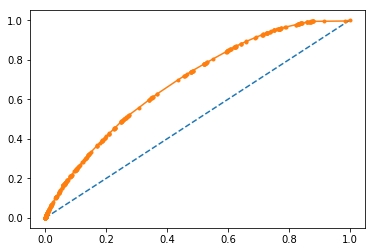

In [160]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill

pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance2'></a>
## Feature Importance
<a href=#top>Top</a>

NameError: name 'plt' is not defined

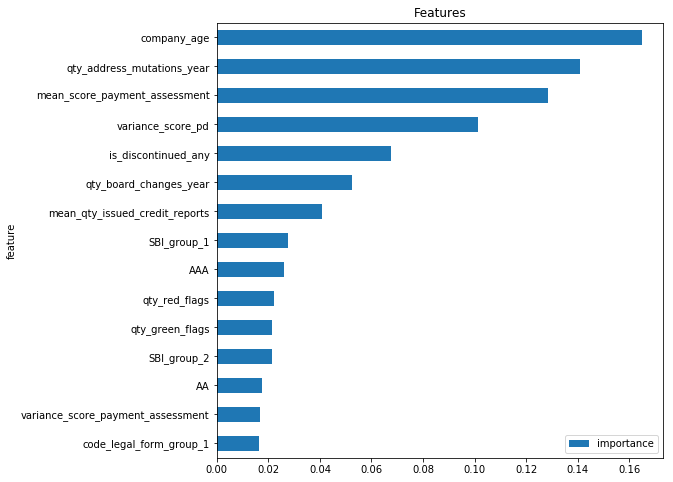

In [161]:
feat_imp = pd.DataFrame({'importance':clf1.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a href=#top>Top</a>
# Feature Importance of Final Model:
<a id='feature_importance_final'></a>

In [91]:
importances = clfDT_Kappa.feature_importances_

In [92]:
len(importances)

34

NameError: name 'plt' is not defined

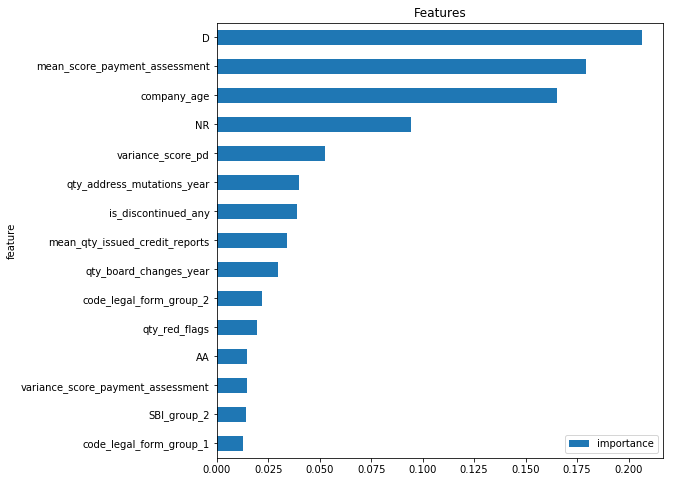

In [93]:
feat_imp = pd.DataFrame({'importance':importances})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='bottom'></a>

<a href=#top>Top</a>
# End